In [9]:
import pandas as pd
import numpy as np
import sys
import seaborn as sns
sys.path.append("E:\Project_HTWD\TumorSpheroids\src")  #Adjust the path when it is needed based on the location of src file
from MLTimeSeriesModel import MLTimeSeriesModel
from Visualization import Visualization
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from matplotlib.patches import Patch
import statsmodels.api as sm
import os
from typing import Union 
import matplotlib.patheffects as pe

This code generates Figure 3 of the manuscript. This can let us to know the whole distriution of time series images and how we picked three different ranges comprising of short, mid, and long ranges.

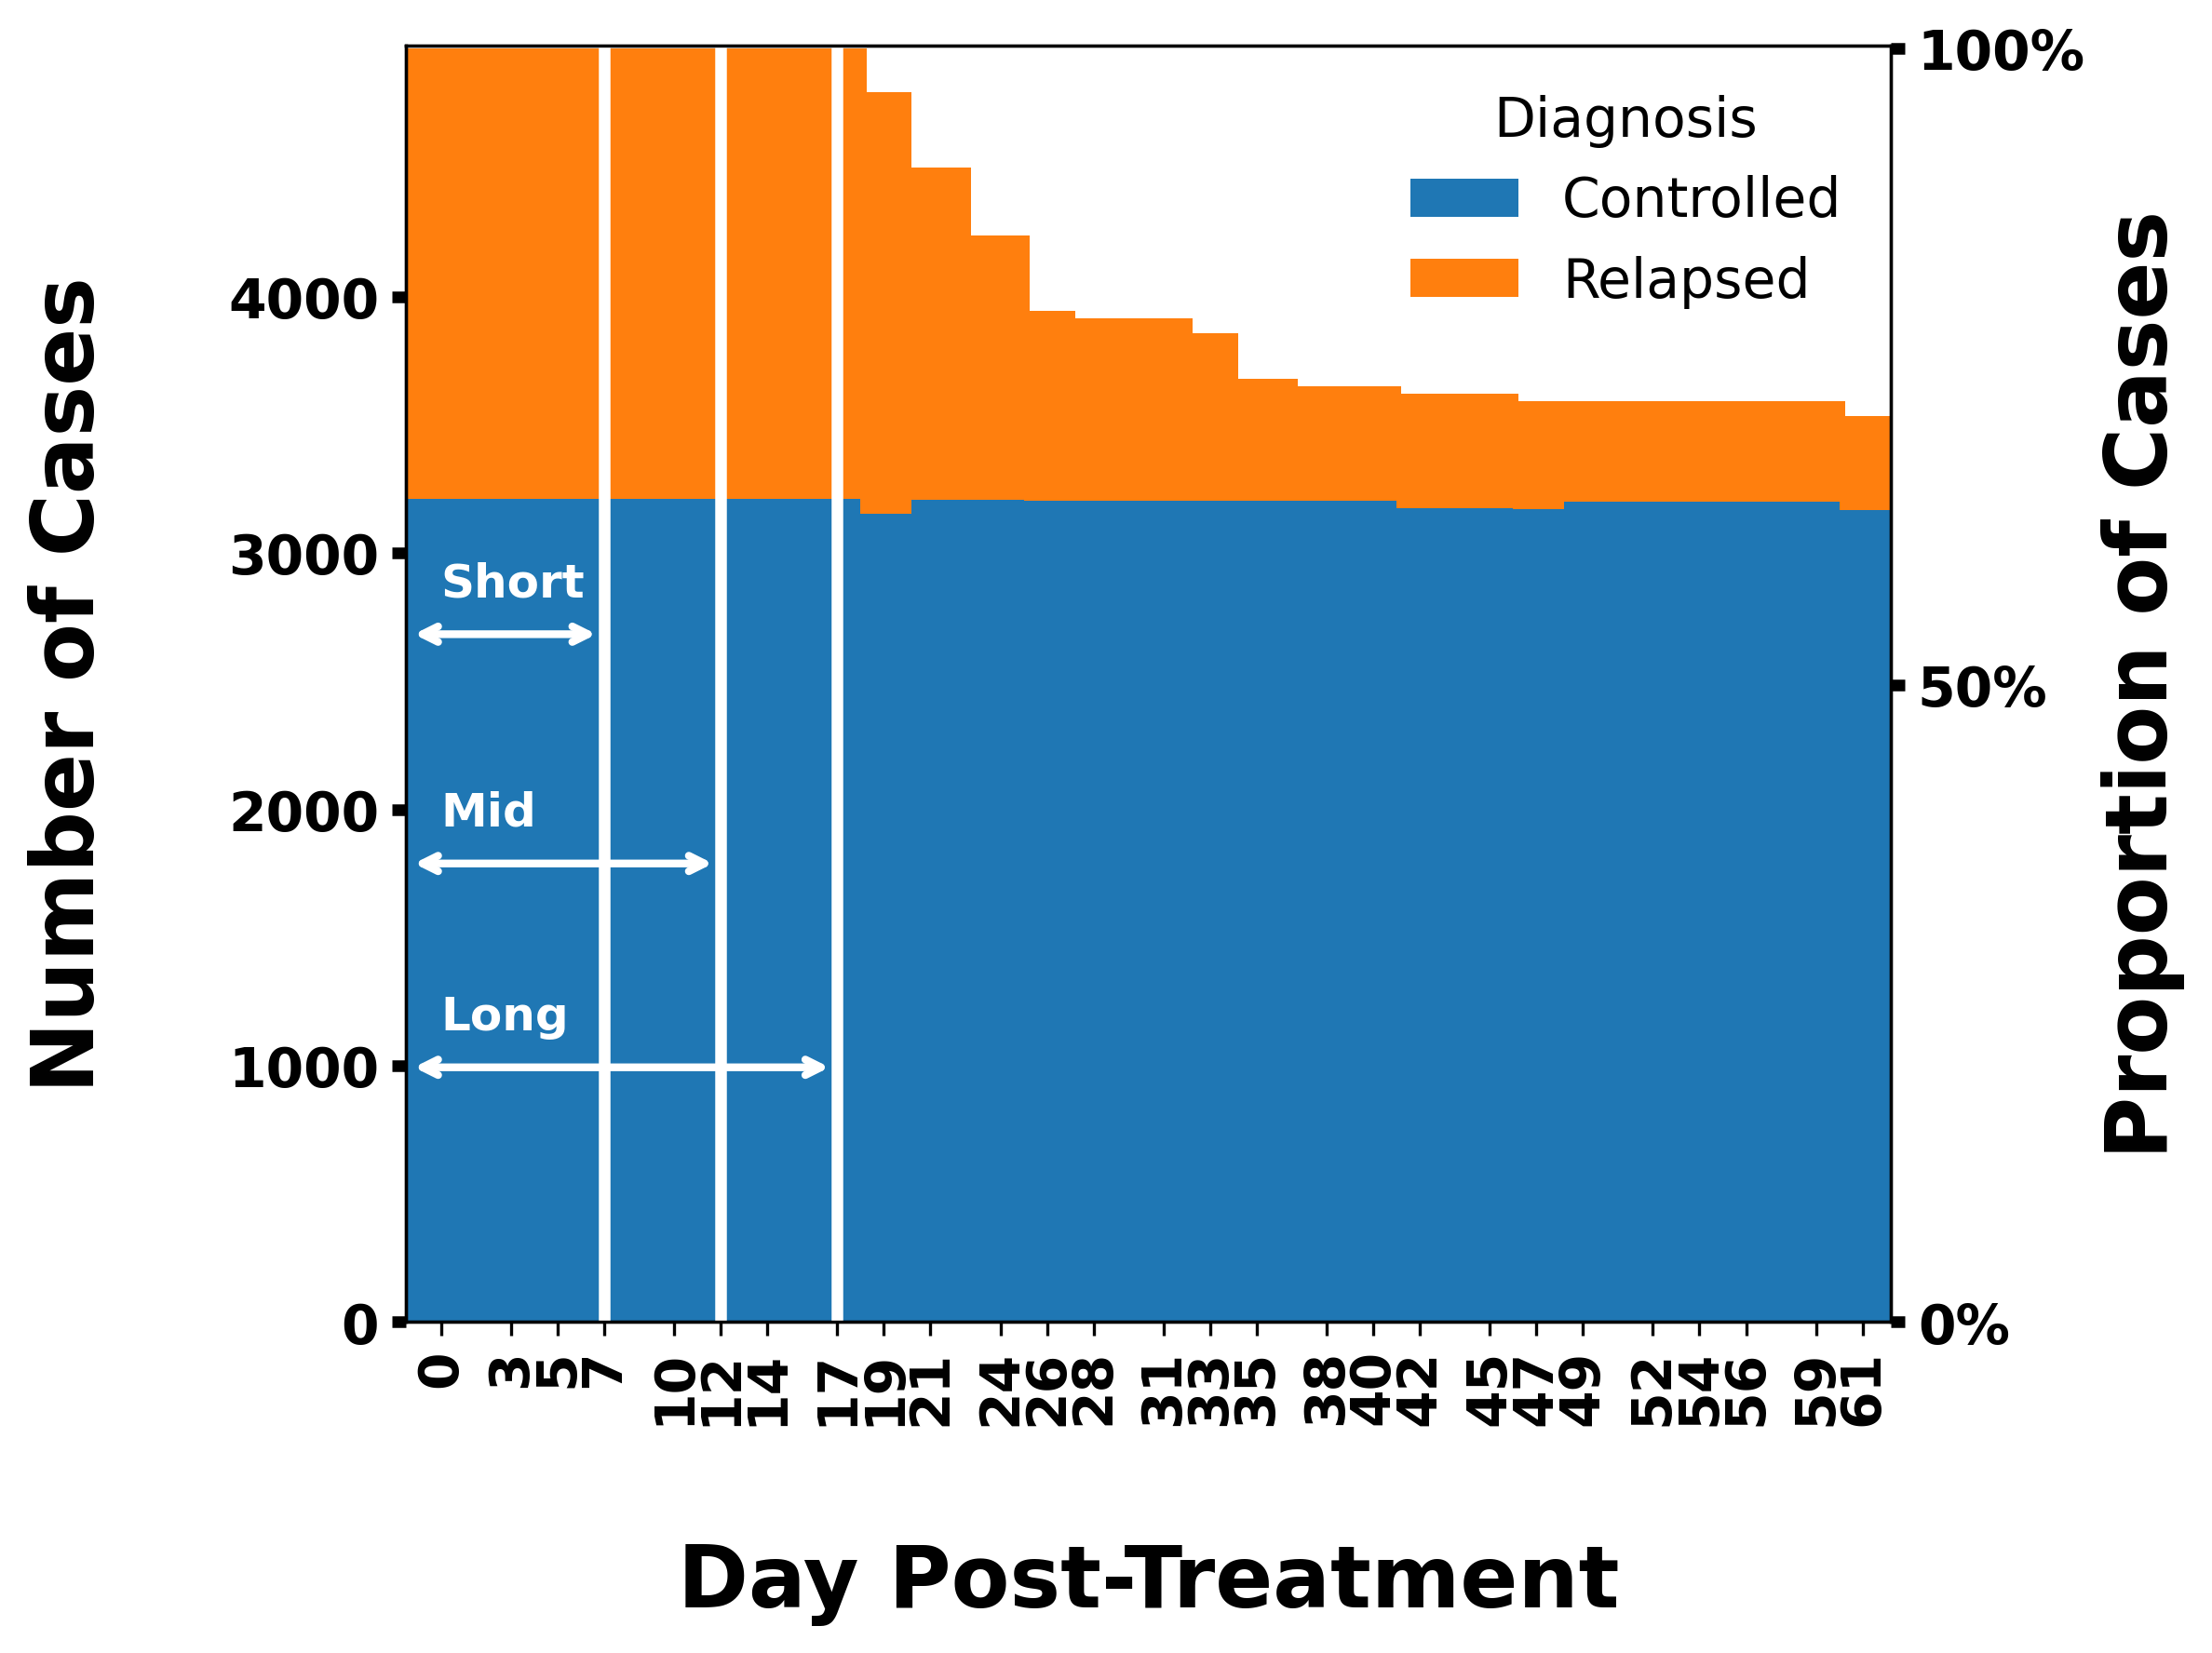

In [ ]:
#////////////////////////////////////////////////////////////////////////////////
#This part of code generates Figure 3 in the manuscript, in which we use the whole spectrum of the data according to the curated data#
#////////////////////////////////////////////////////////////////////////////////
STYLE = {
    "fig": {"size": (8, 6), "dpi": 300},
    "fonts": {
        "axis_label": 22,          # x/y axes label font size
        "axis_label_pad": 30,      # x/y label padding
        "tick": 14,                # tick label size (x & y)
        "tick_weight": "bold",
        "legend": 14,
        "legend_weight": "normal",          
        "legend_title_weight": "normal",    
        "legend_title": 14,
        "secondary_ylabel": 22,
        "secondary_tick": 14,
        "guide_text": 12,          # "Short/Mid/Long" labels
    },
    "ticks": {
        "x_rotation": 90,
        "x_width": 3,
        "y_width": 3,
    },
    "labels": {
        "x": "Day Post-Treatment",
        "y_count": "Number of Cases",
        "y_prop": "Proportion of Cases",
        "legend_title": "Diagnosis",
        "stack_labels": ["Controlled", "Relapsed"],
    },
    "colors": {
        "controlled": "#1f77b4",
        "relapsed":   "#ff7f0e",
        "vline":      "white",
    },
    "bars": {
        "align": "edge",
    },
    "range_guides": {
        "cuts": {"short": 7, "mid": 12, "long": 17},
        "vline_width": 3,
        "arrow_lw": 2.0,
        "label_offset_frac": 0.04,     # fraction of max_count
        "y_pos_frac": {"short": 0.54, "mid": 0.36, "long": 0.20},
    },
    "save": {
        "bbox_inches": "tight",
        "pad_inches": 0.1,
        "format": "pdf",
    }
}

#Load Data, you can change the directory to the location of your data
data = pd.read_csv(r"E:\Project_HTWD\tumorSpheroids\data\Mid_Range.csv")
data2 = pd.read_csv(
    r"E:\Project_HTWD\tumorSpheroids\data\combined_data_merged.csv"
)
# Step 1: Select wells in `data` that have diagnosis 0 or 1
filtered_wells = data[data["diagnosis"].isin([0, 1])]["well"].unique()
# Step 2: Filter `data2` to include only those wells
data2 = data2[data2["well"].isin(filtered_wells)]
plot_data2 = (
    data2[["day", "diagnosis"]]
    .groupby(["day", "diagnosis"])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)
# Ensure "controlled" precedes "relapsed"
plot_data2 = plot_data2[["controlled", "relapsed"]]

days = plot_data2.index.values.astype(float)

#1. Build Contiguous Bin Edges 
left_edge_0     = days[0] - (days[1] - days[0]) / 2
mid_points      = (days[:-1] + days[1:]) / 2
right_edge_last = days[-1] + (days[-1] - days[-2]) / 2

edges      = np.concatenate(([left_edge_0], mid_points, [right_edge_last]))
left_edges = edges[:-1]
widths     = np.diff(edges) * 1.1

#2. Plot 
fig, ax = plt.subplots(figsize=STYLE["fig"]["size"], dpi=STYLE["fig"]["dpi"])

custom_colors = [STYLE["colors"]["controlled"], STYLE["colors"]["relapsed"]]
stack_labels  = STYLE["labels"]["stack_labels"]

bottom = np.zeros(len(plot_data2))
for col, color, lbl in zip(plot_data2.columns, custom_colors, stack_labels):
    ax.bar(
        left_edges,
        plot_data2[col],
        width=widths,
        bottom=bottom,
        color=color,
        label=lbl,
        align=STYLE["bars"]["align"],
    )
    bottom += plot_data2[col].values

# 2.1 Add Secondary Y Axis (Percentage) 
ax2 = ax.twinx()
total_counts = plot_data2.sum(axis=1)
max_count = total_counts.max()

ax.set_ylim(0, max_count * 1.002)
ax2.set_ylim(ax.get_ylim())

ax2.set_yticks([0, 0.5 * max_count, max_count])
ax2.set_yticklabels(["0%", "50%", "100%"],
                    fontsize=STYLE["fonts"]["secondary_tick"],
                    fontweight=STYLE["fonts"]["tick_weight"])
ax2.tick_params(axis="y",
                labelsize=STYLE["fonts"]["secondary_tick"],
                width=STYLE["ticks"]["y_width"])
for label in ax2.get_yticklabels():
    label.set_fontweight(STYLE["fonts"]["tick_weight"])
ax2.set_ylabel(STYLE["labels"]["y_prop"],
               fontsize=STYLE["fonts"]["secondary_ylabel"],
               fontweight="bold")

# 3. Cosmetics 
ax.set_xlabel(STYLE["labels"]["x"],
              fontsize=STYLE["fonts"]["axis_label"],
              fontweight="bold",
              labelpad=STYLE["fonts"]["axis_label_pad"])
ax.set_ylabel(STYLE["labels"]["y_count"],
              fontsize=STYLE["fonts"]["axis_label"],
              fontweight="bold",
              labelpad=STYLE["fonts"]["axis_label_pad"])

# Legend
leg = ax.legend(
    title=STYLE["labels"]["legend_title"],
    prop={"size": STYLE["fonts"]["legend"], "weight": STYLE["fonts"]["legend_weight"]},
    frameon=False,
)
leg.get_title().set_fontsize(STYLE["fonts"]["legend_title"])
leg.get_title().set_fontweight(STYLE["fonts"]["legend_title_weight"])
leg.get_frame().set_facecolor("none")
leg.get_frame().set_edgecolor("none")

# Ticks on x-axis
ax.set_xticks(days)
ax.set_xticklabels(
    days.astype(int),
    rotation=STYLE["ticks"]["x_rotation"],
    ha="center",
    fontsize=STYLE["fonts"]["tick"],
    fontweight=STYLE["fonts"]["tick_weight"],
)

# Y-axis ticks style
ax.tick_params(axis="y",
               labelsize=STYLE["fonts"]["tick"],
               width=STYLE["ticks"]["y_width"])
for label in ax.get_yticklabels():
    label.set_fontweight(STYLE["fonts"]["tick_weight"])

# X-axis limit
ax.set_xlim(left_edges[0], left_edges[-1] + widths[-1])

#  4. Range Guides: Short / Mid / Long 
cuts = STYLE["range_guides"]["cuts"]
for xline in (cuts["short"], cuts["mid"], cuts["long"]):
    ax.axvline(x=xline,
               color=STYLE["colors"]["vline"],
               linewidth=STYLE["range_guides"]["vline_width"],
               zorder=5)

# Y-positions and label offset
y_short = max_count * STYLE["range_guides"]["y_pos_frac"]["short"]
y_mid   = max_count * STYLE["range_guides"]["y_pos_frac"]["mid"]
y_long  = max_count * STYLE["range_guides"]["y_pos_frac"]["long"]
label_offset = max_count * STYLE["range_guides"]["label_offset_frac"]

def guide_arrow_from_left(x1, y, text):
    left_start = ax.get_xlim()[0]  # start exactly at the left axis limit
    ax.annotate(
        "",
        xy=(x1, y),
        xytext=(left_start, y),
        arrowprops=dict(arrowstyle="<->",
                        lw=STYLE["range_guides"]["arrow_lw"],
                        color=STYLE["colors"]["vline"]),
        zorder=6,
    )
    ax.text(
        0, y + label_offset, text,
        va="center", ha="left",
        fontsize=STYLE["fonts"]["guide_text"],
        fontweight="bold",
        color=STYLE["colors"]["vline"],
        zorder=7
    )

guide_arrow_from_left(cuts["short"], y_short, "Short")
guide_arrow_from_left(cuts["mid"],   y_mid,   "Mid")
guide_arrow_from_left(cuts["long"],  y_long,  "Long")

#  Finalize 
plt.tight_layout(pad=1.0)
plt.savefig(r"E:\Project_HTWD\tumorSpheroids\Results\Figure 3.pdf",
            format=STYLE["save"]["format"],
            dpi=STYLE["fig"]["dpi"],
            bbox_inches=STYLE["save"]["bbox_inches"],
            pad_inches=STYLE["save"]["pad_inches"])
plt.show()


Here we aim to generate the figure 4A and 4B plus Figures S.3

In [3]:
#////////////////////////////////////////////////////////////////////////////////
#You can optionally change the input and output directories in the following part#
#////////////////////////////////////////////////////////////////////////////////
dataset_paths = {
    "short": r"E:\Project_HTWD\tumorSpheroids\data\Short_Range.csv",
    "mid": r"E:\Project_HTWD\tumorSpheroids\data\Mid_Range.csv",
    "long": r"E:\Project_HTWD\tumorSpheroids\data\Long_Range.csv"
}

output_dir = r"E:\Project_HTWD\tumorSpheroids\Results"
os.makedirs(output_dir, exist_ok=True)

In [4]:
feature_selection_methods = {
    "SelectKBest_f_classif": "F_classif",
    "PCA": "PCA",
    "SelectKBest_mutual_info": "Mutual_info",
    "LassoSelector": "LassoSelector",
    "TreeBasedSelector": "TreeBasedSelector",
    "RecursiveFeatureElimination": "RFE",
}

models = {
    "LogisticRegression": "LogisticRegression",
    "SVM": "SVM",
    "XGBoost": "XGBoost",
    "LDA": "LDA",
    "HistGradientBoosting": "HistGBoost",
    "MLPClassifier": "MLPClassifier",
}

def _rename_with_suffix(col_name: str) -> str:
    """Keep _AUC / _Accuracy suffix while shortening the model name."""
    if col_name.endswith("_AUC"):
        base = col_name[:-4]
        return f"{models.get(base, base)}_AUC"
    elif col_name.endswith("_Accuracy"):
        base = col_name[:-9]
        return f"{models.get(base, base)}_Accuracy"
    return models.get(col_name, col_name)

In [6]:
# Use the ORIGINAL names (dict keys) for training/eval; map to short names only when saving
fs_list = list(feature_selection_methods.keys())
model_list = list(models.keys())

for ds_name, csv_path in dataset_paths.items():
    print(f"\n=== Processing dataset: {ds_name} ===")
    try:
        # ---- Load ----
        data = pd.read_csv(csv_path)

        # ---- Basic cleaning / target & aux columns ----
        data = data.dropna(subset=['diagnosis'])
        data['DaysofRelapse'] = data['DaysofRelapse'].fillna(0)

        dose_values_all   = data[['dose (Gy)']].copy()
        days_relapse_all  = data['DaysofRelapse'].copy()
        plate_all         = data['plate'].copy()
        well_all          = data['well'].copy()

        # ---- Drop non-feature columns (leave 'diagnosis' for y) ----
        columns_to_drop = ['well', 'DaysofRelapse', 'plate', 'RT', 'time',
                           'temperature', 'dose (Gy)', 'CEM43']
        present_to_drop = [c for c in columns_to_drop if c in data.columns]
        feats_df = data.drop(columns=present_to_drop)

        X = feats_df.drop(columns=['diagnosis'])
        y = feats_df['diagnosis']

        # ---- Split (keep DataFrames to preserve indices for subset selection) ----
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.5, random_state=42, stratify=y
        )

        dose_values_test     = dose_values_all.loc[X_test.index]
        days_of_relapse_test = days_relapse_all.loc[X_test.index]
        well_test            = well_all.loc[X_test.index]

        # ---- Init result holders (use lists of original names) ----
        results_auc = pd.DataFrame(index=fs_list, columns=model_list, dtype=float)
        results_acc = pd.DataFrame(index=fs_list, columns=model_list, dtype=float)

        # ---- Loop over FS & Models ----
        for fs_method in fs_list:
            for model_name in model_list:
                try:
                    ml_model = MLTimeSeriesModel(variance_threshold=0.01)

                    # pick FS + model
                    ml_model.select_feature_selection(fs_method)
                    ml_model.select_model(model_name)
                    ml_model.build_pipeline()

                    # fit & eval on full test
                    ml_model.fit(X_train, y_train)
                    metrics_full = ml_model.evaluate(X_test, y_test)

                    results_auc.loc[fs_method, model_name] = metrics_full.get("roc_auc", np.nan)
                    results_acc.loc[fs_method, model_name] = metrics_full.get("accuracy", np.nan)

                except Exception as inner_e:
                    print(f"Error with {fs_method} + {model_name}: {inner_e}")
                    results_auc.loc[fs_method, model_name] = np.nan
                    results_acc.loc[fs_method, model_name] = np.nan

        # ---- Save per-dataset outputs (AFTER loops) ----
        combined = pd.concat(
            [results_auc.add_suffix('_AUC'), results_acc.add_suffix('_Accuracy')],
            axis=1
        )

        # Apply short names to index (feature selectors) and columns (models + suffixes)
        combined_renamed = combined.copy()
        combined_renamed.index = [feature_selection_methods.get(ix, ix) for ix in combined_renamed.index]
        combined_renamed.columns = [_rename_with_suffix(c) for c in combined_renamed.columns]

        out_base = os.path.join(output_dir, f"{ds_name}_results")
        combined_renamed.to_csv(f"{out_base}_combined_auc_acc.csv", index=True)

    except Exception as e:
        print(f"FAILED dataset '{ds_name}': {e}")


=== Processing dataset: short ===

=== Processing dataset: mid ===

=== Processing dataset: long ===


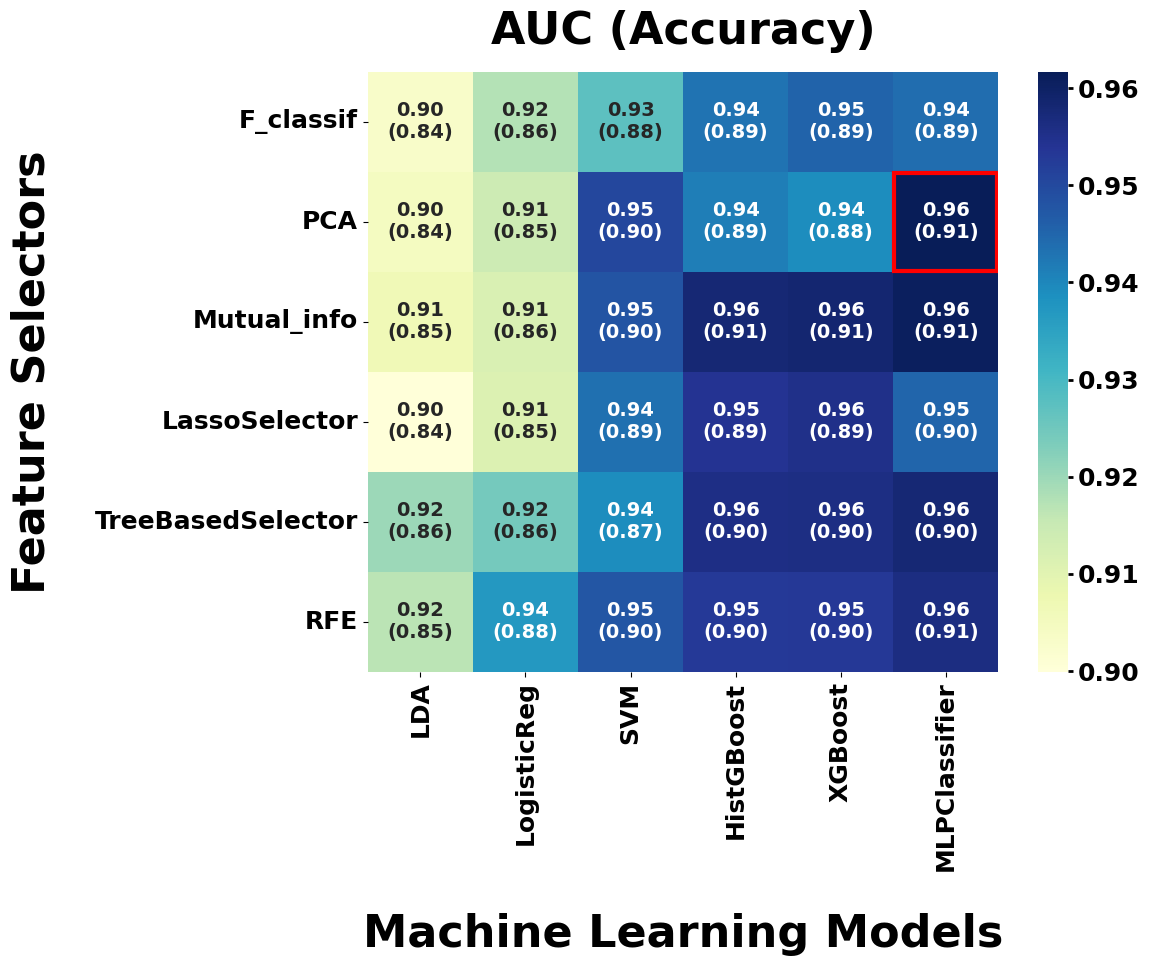

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches

#  0. Config 
plt.rcParams.update({
    "font.size": 18,
    "axes.titlesize": 28,
    "axes.labelsize": 26,
    "xtick.labelsize": 22,
    "ytick.labelsize": 22,
    "legend.fontsize": 18,
    "legend.title_fontsize": 18,
    "figure.figsize": (14, 12),
    "axes.linewidth": 2,
})

original_models = ["LDA", "LogisticRegression", "SVM", "HistGBoost", "XGBoost", "MLPClassifier"]
model_name_map = {'LogisticRegression': 'LogisticReg'}
display_models = [model_name_map.get(m, m) for m in original_models]
#2. Plot A: Heatmap
df_mid = pd.read_csv(os.path.join(output_dir, "mid_results_combined_auc_acc.csv"), index_col=0)
auc_df = df_mid[[f"{m}_AUC" for m in original_models]]
acc_df = df_mid[[f"{m}_Accuracy" for m in original_models]]
auc_df.columns = acc_df.columns = display_models
annot = pd.DataFrame('', index=auc_df.index, columns=auc_df.columns)
for fs in auc_df.index:
    for model in auc_df.columns:
        annot.loc[fs, model] = f"{auc_df.loc[fs, model]:.2f}\n({acc_df.loc[fs, model]:.2f})"
plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    auc_df.astype(float),
    annot=annot.values,
    fmt="",
    cmap="YlGnBu",
    cbar_kws={'label': ''},
    annot_kws={"size": 14, "weight": "bold"}
)
row_idx = auc_df.index.tolist().index("PCA")
col_idx = auc_df.columns.tolist().index("MLPClassifier")
ax.add_patch(patches.Rectangle((col_idx + 0.01, row_idx + 0.01), 0.98, 0.98,
    edgecolor='red', facecolor='none', linewidth=3))
ax.set_title("AUC (Accuracy)", fontsize=32, fontweight='bold', pad=20)
ax.set_xlabel("Machine Learning Models", fontsize=32, fontweight='bold', labelpad=30)
ax.set_ylabel("Feature Selectors", fontsize=32, fontweight='bold', labelpad=30)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=18, fontweight='bold')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=18, fontweight='bold')
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=18, width=2)
for lbl in cbar.ax.get_yticklabels(): lbl.set_fontweight('bold')
plt.tight_layout()
plt.savefig(r"E:\Project_HTWD\TumorSpheroids\Results\Figure 4A.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.show()


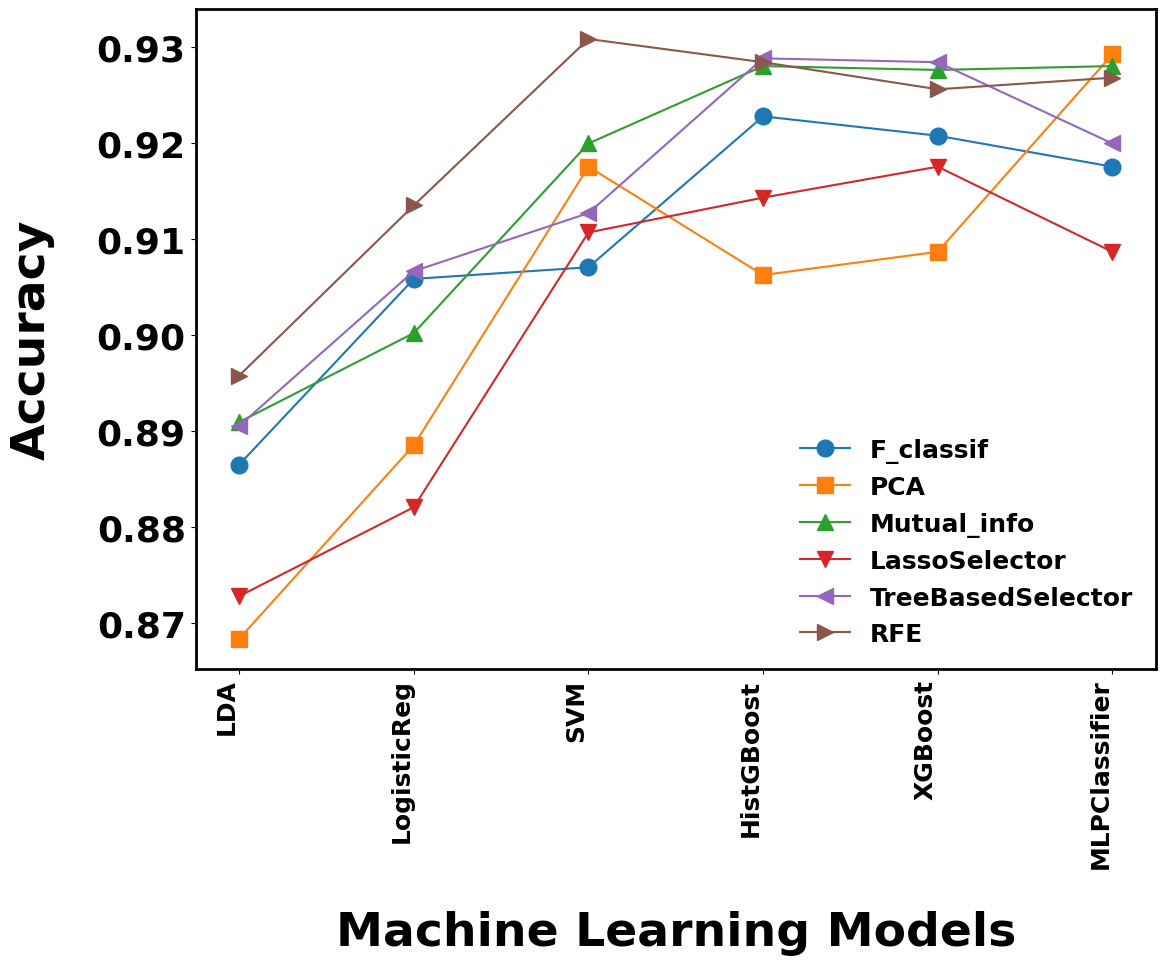

In [6]:

#3. Plot B: Lineplot 
# --- 3. Plot B: Lineplot (with model_name_map for display names) ---
csv_path = os.path.join(output_dir, "long_results_combined_auc_acc.csv")

df_mid = pd.read_csv(csv_path, index_col=0)
if 'feature_selector' not in df_mid.columns:
    try:
        df_mid = df_mid.reset_index(names='feature_selector')
    except TypeError:
        df_mid = df_mid.reset_index()
        if 'index' in df_mid.columns:
            df_mid = df_mid.rename(columns={'index': 'feature_selector'})
        else:
            df_mid = df_mid.rename(columns={df_mid.columns[0]: 'feature_selector'})

acc_cols = [c for c in df_mid.columns if c.endswith('_Accuracy')]

df_mid = df_mid.melt(
    id_vars='feature_selector',
    value_vars=acc_cols,
    var_name='model',
    value_name='accuracy'
)

# Strip suffix to get the (short) model keys from CSV
df_mid['model'] = df_mid['model'].str.replace('_Accuracy', '', regex=False)

# >>> APPLY THE MAP FOR DISPLAY NAMES <<<
# original_models, model_name_map, and display_models are from your snippet above
df_mid['model_display'] = df_mid['model'].map(model_name_map).fillna(df_mid['model'])

# Order axis by display names
present_order = [m for m in display_models if m in df_mid['model_display'].unique()]
df_mid['model_display'] = pd.Categorical(df_mid['model_display'],
                                          categories=present_order, ordered=True)

# Plot using model_display
markers = ['o', 's', '^', 'v', '<', '>', 'P', 'X']
colors = sns.color_palette("tab10", n_colors=df_mid['feature_selector'].nunique())

plt.figure(figsize=(12, 10))
for i, selector in enumerate(df_mid['feature_selector'].unique()):
    subset = df_mid[df_mid['feature_selector'] == selector].sort_values('model_display')
    x = subset['model_display'].cat.codes.values
    y = subset['accuracy'].values
    plt.plot(
        x, y,
        label=selector,
        marker=markers[i % len(markers)],
        linestyle='-',
        color=colors[i],
        markersize=12
    )

plt.xticks(
    ticks=range(len(present_order)),
    labels=present_order,
    rotation=90, ha='right',
    fontsize=18, fontweight='bold'
)
plt.yticks(fontsize=26, fontweight='bold')
plt.ylabel('Accuracy', fontsize=34, fontweight='bold', labelpad=30)
plt.xlabel("Machine Learning Models", fontsize=34, fontweight='bold', labelpad=30)
plt.legend(loc='lower right', prop={'weight': 'bold', 'size': 18}, frameon=False)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "Figure_4B.pdf"), format="pdf", bbox_inches="tight", dpi=300)
plt.show()



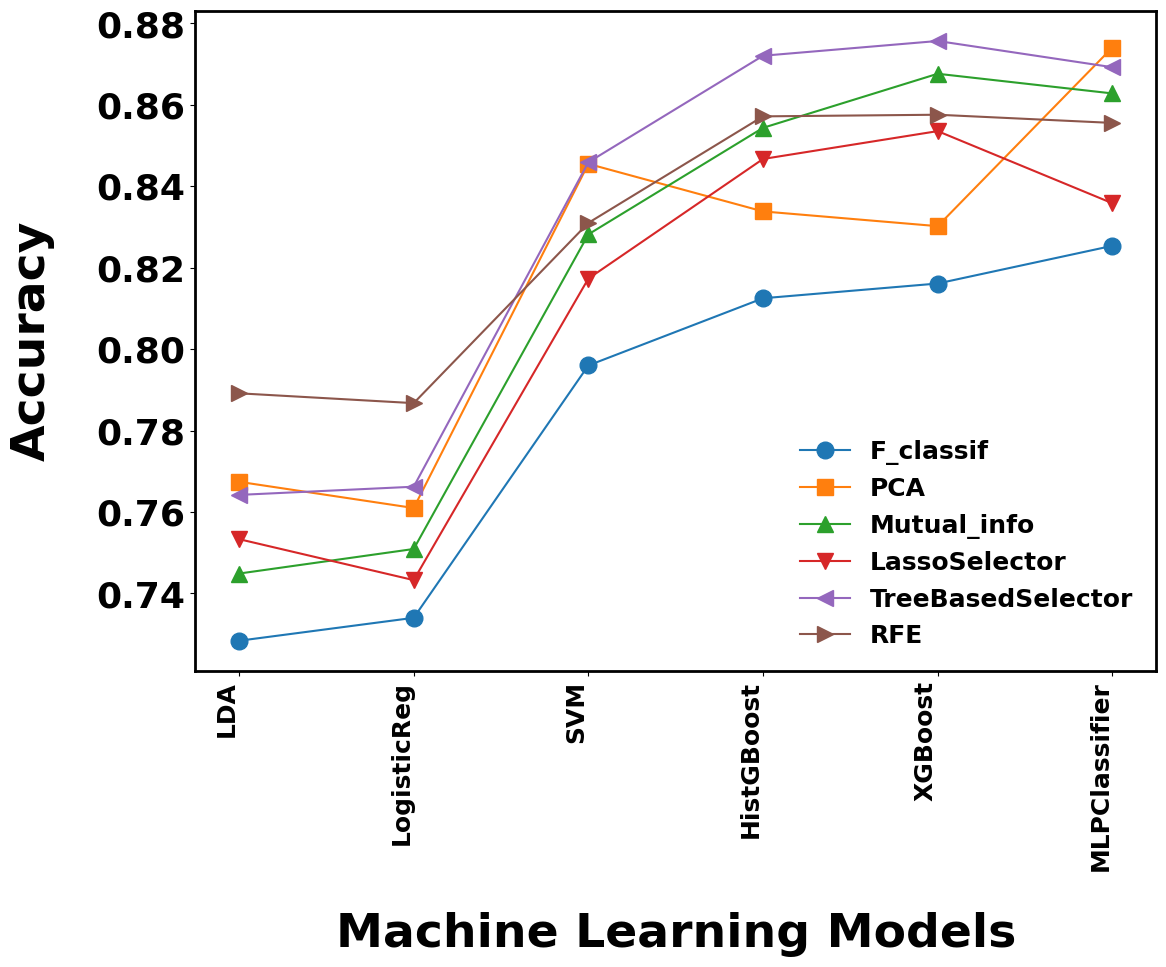

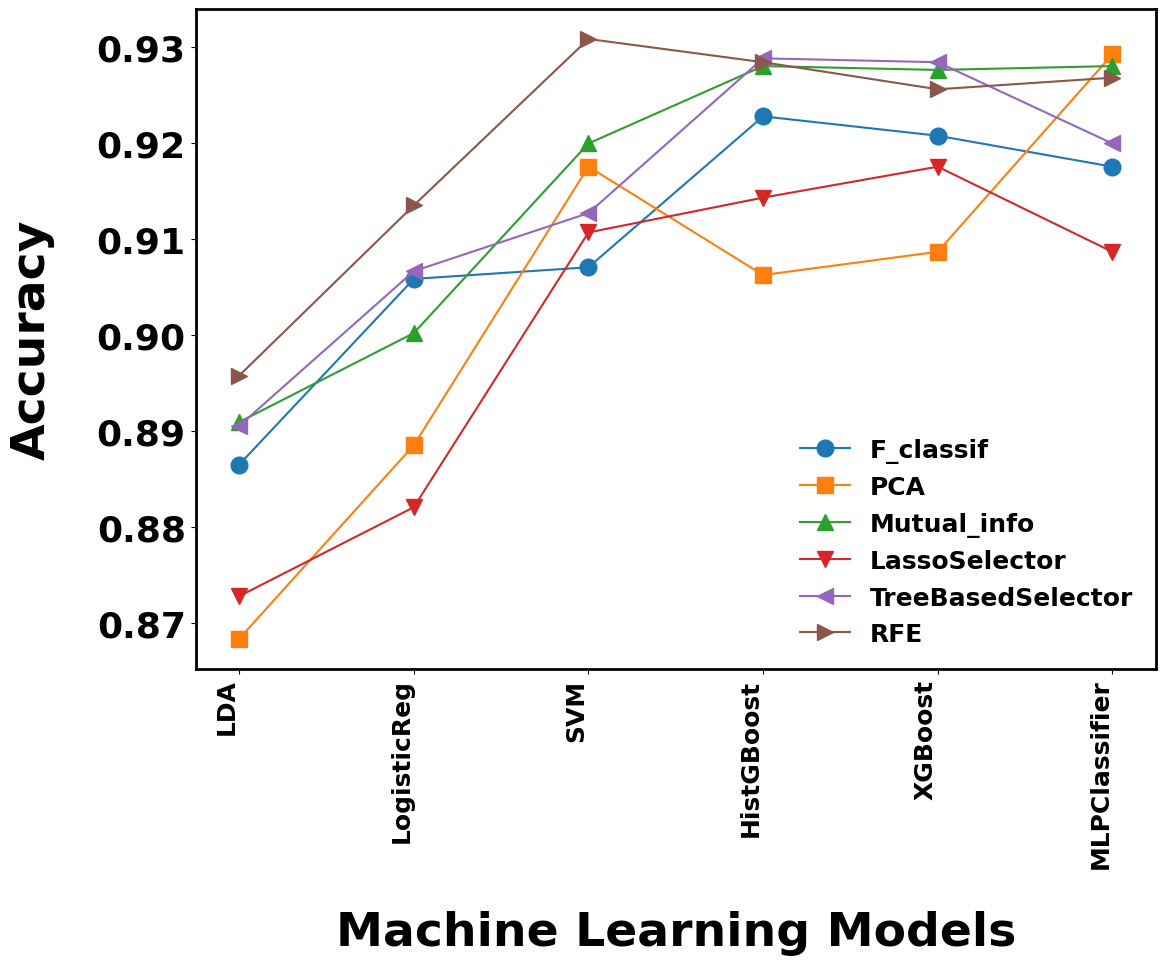

In [7]:
# --- Plot B: Lineplots for short and long datasets (Figure S3) ---

datasets_to_plot = {
    "short": "short_results_combined_auc_acc.csv",
    "long": "long_results_combined_auc_acc.csv"
}

for ds_name, filename in datasets_to_plot.items():
    csv_path = os.path.join(output_dir, filename)

    df_temp = pd.read_csv(csv_path, index_col=0)
    if 'feature_selector' not in df_temp.columns:
        try:
            df_temp = df_temp.reset_index(names='feature_selector')
        except TypeError:
            df_temp = df_temp.reset_index()
            if 'index' in df_temp.columns:
                df_temp = df_temp.rename(columns={'index': 'feature_selector'})
            else:
                df_temp = df_temp.rename(columns={df_temp.columns[0]: 'feature_selector'})

    acc_cols = [c for c in df_temp.columns if c.endswith('_Accuracy')]

    df_temp = df_temp.melt(
        id_vars='feature_selector',
        value_vars=acc_cols,
        var_name='model',
        value_name='accuracy'
    )

    # Strip suffix to get the (short) model keys from CSV
    df_temp['model'] = df_temp['model'].str.replace('_Accuracy', '', regex=False)

    # Apply the mapping for display names
    df_temp['model_display'] = df_temp['model'].map(model_name_map).fillna(df_temp['model'])

    # Order axis by display names
    present_order = [m for m in display_models if m in df_temp['model_display'].unique()]
    df_temp['model_display'] = pd.Categorical(df_temp['model_display'],
                                              categories=present_order, ordered=True)

    # Plot
    markers = ['o', 's', '^', 'v', '<', '>', 'P', 'X']
    colors = sns.color_palette("tab10", n_colors=df_temp['feature_selector'].nunique())

    plt.figure(figsize=(12, 10))
    for i, selector in enumerate(df_temp['feature_selector'].unique()):
        subset = df_temp[df_temp['feature_selector'] == selector].sort_values('model_display')
        x = subset['model_display'].cat.codes.values
        y = subset['accuracy'].values
        plt.plot(
            x, y,
            label=selector,
            marker=markers[i % len(markers)],
            linestyle='-',
            color=colors[i],
            markersize=12
        )

    plt.xticks(
        ticks=range(len(present_order)),
        labels=present_order,
        rotation=90, ha='right',
        fontsize=18, fontweight='bold'
    )
    plt.yticks(fontsize=26, fontweight='bold')
    plt.ylabel('Accuracy', fontsize=34, fontweight='bold', labelpad=30)
    plt.xlabel("Machine Learning Models", fontsize=34, fontweight='bold', labelpad=30)
    plt.legend(loc='lower right', prop={'weight': 'bold', 'size': 18}, frameon=False)

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"Figure_S3_{ds_name}.pdf"),
                format="pdf", bbox_inches="tight", dpi=300)
    plt.show()

Here, we generate results based on the selected ML model and Feature selector. We should note that the results are exteremly close to each other and each feature selector can be chosen by MLPClassifier.

In [8]:
# In this part of codes, we generate the results based on the selected feature selector and ML models. 
def calc_day_of_diagnosis(
        dor: Union[float, int],   
        ds_label: str
) -> float:                       #   returning a float; NaN is still a float

    if pd.isna(dor) or dor == 0:
        return np.nan

    try:
        idx = OBS_DAYS.index(int(dor))
        future_idx = idx + 3
        if future_idx >= len(OBS_DAYS):
            return np.nan

        future_day = OBS_DAYS[future_idx]
        return future_day - range_map[ds_label]

    except ValueError:
        return np.nan

def extract_cell_line(well_name):
    if "FaDu" in well_name:
        return "FaDu"
    elif "SAS" in well_name:
        return "SAS"
    else:
        return "Unknown"

# Step 1: Generate train/test wells from short dataset (only once)
short_df = pd.read_csv(dataset_paths["short"])
short_df = short_df.dropna(subset=["diagnosis"])
train_wells, test_wells = train_test_split(
    short_df["well"], test_size=0.5, random_state=42, stratify=short_df["diagnosis"]
)
range_map = {"short": 7, "mid": 12, "long": 17}
# Step 2: Apply same train/test split to all datasets
for label, path in dataset_paths.items():
    print(f"\nProcessing {label} dataset...")
    full_df = pd.read_csv(path)
    full_df = full_df.dropna(subset=['diagnosis'])
    full_df['DaysofRelapse'] = full_df['DaysofRelapse'].fillna(0)
    full_df['well'] = full_df['well'].astype(str)

    train_df = full_df[full_df['well'].isin(train_wells)].copy()
    test_df = full_df[full_df['well'].isin(test_wells)].copy()

    def preprocess(df):
        meta_cols = df[['well', 'DaysofRelapse', 'plate', 'dose (Gy)', 'CEM43', 'time', 'temperature']].copy()
        features = df.drop(columns=['well', 'DaysofRelapse', 'plate', 'RT', 'time', 'temperature', 'dose (Gy)', 'CEM43', 'diagnosis'])
        labels = df['diagnosis']
        return features, labels, meta_cols

    X_train, y_train, meta_train = preprocess(train_df)
    X_test, y_test, meta_test = preprocess(test_df)

    ml_model = MLTimeSeriesModel()
    ml_model.select_feature_selection("PCA")
    ml_model.select_model("MLPClassifier")
    ml_model.build_pipeline()
    ml_model.fit(X_train, y_train)
    results = ml_model.cross_validate(X_train, y_train)
    y_pred, y_proba = ml_model.predict(X_test)
    y_pred_series = pd.Series(y_pred, index=X_test.index)

    results['fold_details_df'].to_csv(os.path.join(output_dir, f"{label}_cv_fold_metrics.csv"), index=False)
    pd.DataFrame({
        'mean_auc': [results['mean_auc']],
        'std_auc': [results['std_auc']],
        'mean_accuracy': [results['mean_accuracy']],
        'std_accuracy': [results['std_accuracy']],
        'mean_f1': [results['mean_f1']],
        'std_f1': [results['std_f1']],
    }).to_csv(os.path.join(output_dir, f"{label}_cv_summary.csv"), index=False)
    range_map = {'short': 7, 'mid': 12, 'long': 17}
    metrics = ml_model.evaluate(X_test, y_test)
    pd.DataFrame.from_dict(metrics['classification_report']).T.to_csv(
        os.path.join(output_dir, f"{label}_classification_metrics.csv"))

    df_pred = pd.DataFrame({"y_true": y_test, "y_pred": y_pred_series, "DoR": meta_test['DaysofRelapse']})
    df_pred = df_pred[(df_pred["DoR"] > 0) & (df_pred["DoR"] < 61)]
    grouped = df_pred.groupby("DoR")
    correct_counts = grouped.apply(lambda df: (df["y_true"] == df["y_pred"]).sum())
    total_samples = grouped.size()
    accuracy = correct_counts / total_samples
    all_days = total_samples.index.tolist()
    pd.DataFrame({"DoR": all_days, "Accuracy": accuracy.values, "TotalSamples": total_samples.values}) \
        .to_csv(os.path.join(output_dir, f"{label}_accuracy_by_DoR.csv"), index=False)

    test_base_df = meta_test.copy()
    test_base_df['diagnosis'] = y_test
    test_base_df['cell_line'] = test_base_df['well'].apply(extract_cell_line)
    test_base_df['DaysofRelapse'] = pd.to_numeric(test_base_df['DaysofRelapse'], errors='coerce').fillna(0)
    OBS_DAYS = [0, 3, 5, 7, 10, 12, 14, 17, 19, 21, 24, 26, 28,
            31, 33, 35, 38, 40, 42, 45, 47, 49, 52, 54, 56, 59, 61]
    test_base_df['day_of_diagnosis'] = test_base_df['DaysofRelapse'] \
        .apply(lambda x: calc_day_of_diagnosis(x, label))
# Already defined earlier, shown here for clarity
    

    scp_df = test_base_df.groupby(['plate', 'cell_line']) \
        .apply(lambda df: (df['diagnosis'] == 1).sum() / len(df)).reset_index(name='SCP')

    controlled_indices = test_base_df[test_base_df['DaysofRelapse'] == 0].index
    relapsed_indices = test_base_df[test_base_df['DaysofRelapse'] > 0].index

    def make_acc_df(indices, target_label):
        df = test_base_df.loc[indices].copy()
        df['true_label'] = y_test.loc[indices]
        df['pred_label'] = y_pred_series.loc[indices]
        acc_name = f"{target_label}_accuracy"
        acc = df.groupby(['plate', 'cell_line']).apply(
            lambda g: (g['pred_label'] == (1 if target_label == 'controlled' else 0)).mean()
        ).reset_index(name=acc_name)
        return acc

    controlled_acc_df = make_acc_df(controlled_indices, 'controlled')
    relapsed_acc_df = make_acc_df(relapsed_indices, 'relapsed')

    merged_df = pd.merge(controlled_acc_df, relapsed_acc_df, on=['plate', 'cell_line'], how='outer')
    merged_df = pd.merge(merged_df, scp_df, on=['plate', 'cell_line'], how='left')
    merged_df['relapsed_accuracy'].fillna(0, inplace=True)

    df_controlled = merged_df[merged_df['SCP'] > 0]
    df_relapsed = merged_df[merged_df['SCP'] < 1]
    
    df_controlled.to_csv(os.path.join(output_dir, f"{label}_ctrl.csv"), index=False)
    df_relapsed.to_csv(os.path.join(output_dir, f"{label}_rela.csv"), index=False)

    test_base_df = test_base_df.copy()
    test_base_df['prediction'] = y_pred_series
    test_base_df['prediction_proba'] = y_proba
    test_base_df.rename(columns={'DaysofRelapse': 'DoR', 'dose (Gy)': 'dose'}, inplace=True)
    test_base_df.to_csv(os.path.join(output_dir, f"{label}_all_predictions.csv"), index=False)



Processing short dataset...

Processing mid dataset...

Processing long dataset...


This code provides Figures including Figure 5, Figure 6, Figure 7, and in Supp Materials Figures S4-S12 and Table S1 and S3

Reprocessing plots for: short
CTRL annotated plates: 120/120
RELA annotated plates: 74/74
📉 Short range: Slope (β₁) = -0.0336 [1/d], E-folding time (τ) = 29.80 d, Half-life (t₁/₂) = 20.66 d
[short/short] Avg Controlled Accuracy @ SCP=1: 0.9415 (n=45)
[short/short] Avg Relapsed  Accuracy @ SCP=0: 0.8903 (n=27)
[short/short] --- Per Cell-Line ---
  FaDu: Ctrl@SCP=1 0.9309 (n=25) | Rela@SCP=0 0.8846 (n=11)
  SAS: Ctrl@SCP=1 0.9562 (n=20) | Rela@SCP=0 0.8747 (n=16)
Reprocessing plots for: mid
CTRL annotated plates: 120/120
RELA annotated plates: 74/74
📉 Mid range: Slope (β₁) = -0.0409 [1/d], E-folding time (τ) = 24.45 d, Half-life (t₁/₂) = 16.95 d
[mid/mid] Avg Controlled Accuracy @ SCP=1: 0.9665 (n=45)
[mid/mid] Avg Relapsed  Accuracy @ SCP=0: 0.9498 (n=27)
[mid/mid] --- Per Cell-Line ---
  FaDu: Ctrl@SCP=1 0.9645 (n=25) | Rela@SCP=0 0.9522 (n=11)
  SAS: Ctrl@SCP=1 0.9711 (n=20) | Rela@SCP=0 0.9387 (n=16)


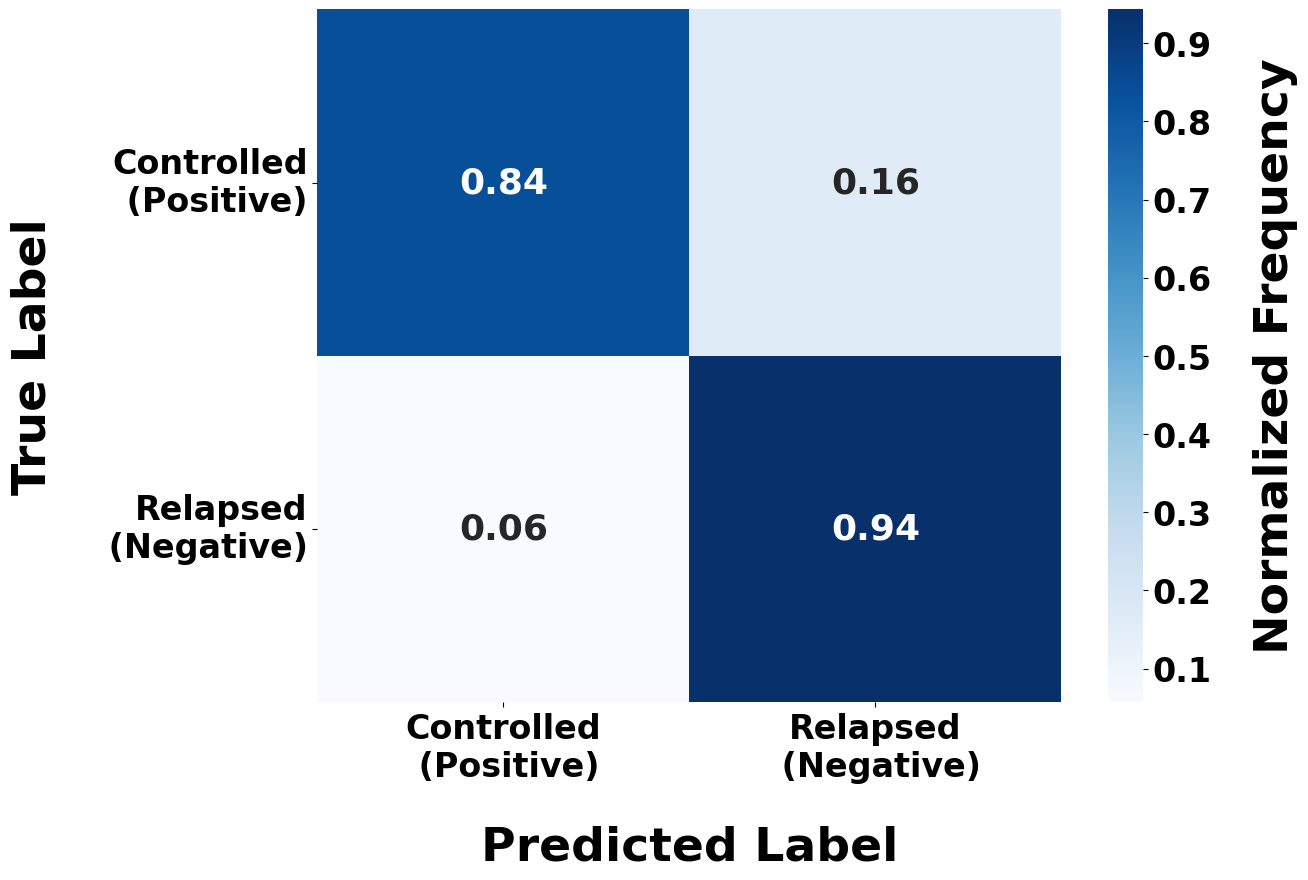

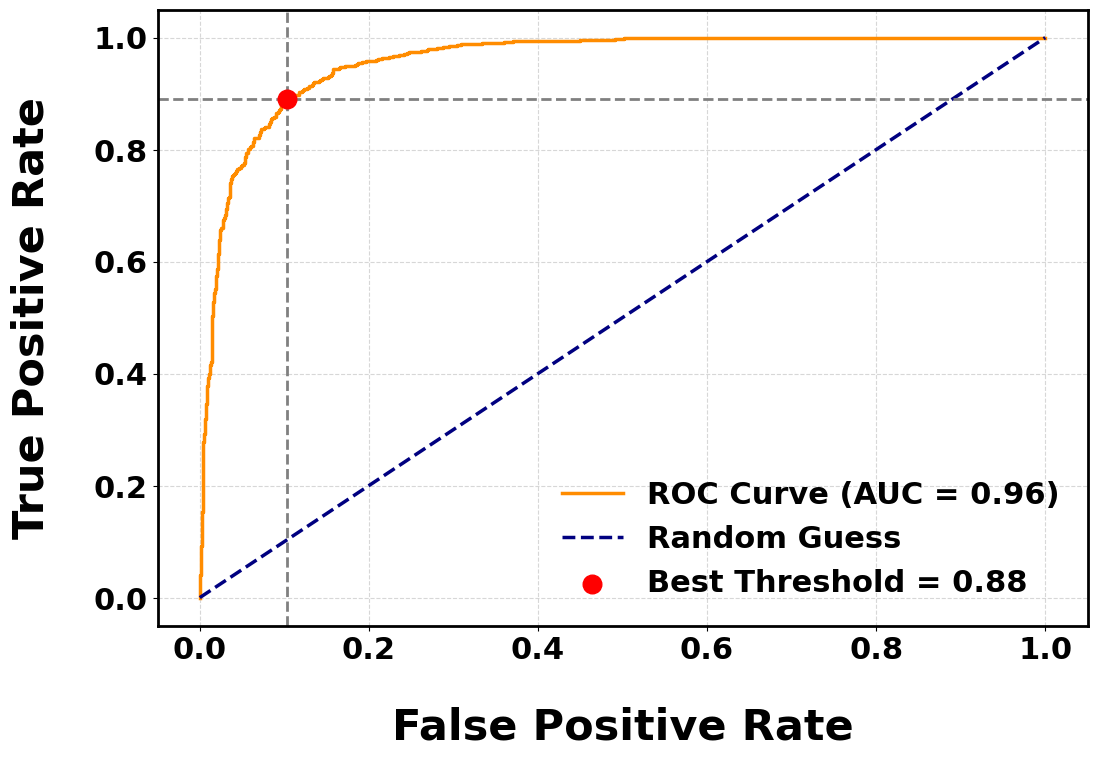

Reprocessing plots for: long
CTRL annotated plates: 120/120
RELA annotated plates: 74/74
📉 Long range: Slope (β₁) = -0.0312 [1/d], E-folding time (τ) = 32.07 d, Half-life (t₁/₂) = 22.23 d
[long/long] Avg Controlled Accuracy @ SCP=1: 0.9819 (n=45)
[long/long] Avg Relapsed  Accuracy @ SCP=0: 0.9753 (n=27)
[long/long] --- Per Cell-Line ---
  FaDu: Ctrl@SCP=1 0.9817 (n=25) | Rela@SCP=0 0.9896 (n=11)
  SAS: Ctrl@SCP=1 0.9811 (n=20) | Rela@SCP=0 0.9627 (n=16)


In [10]:
import os
import pandas as pd
import numpy as np


labels     = ["short", "mid", "long"]
output_dir = r"E:\Project_HTWD\tumorSpheroids\Results"
range_map  = {"short": 7, "mid": 12, "long": 17}

def _unique_plate_meta(df_all_preds: pd.DataFrame) -> pd.DataFrame:
    """
    Build a unique mapping (plate, cell_line) -> (dose, time, temperature).
    If multiple rows exist for a plate+cell_line, any differing values are
    resolved deterministically by taking the first after sorting.
    """
    cols = ["plate", "cell_line", "dose", "time", "temperature"]
    # Keep only needed columns and drop rows without plate/cell_line
    meta = (df_all_preds
            [cols]
            .dropna(subset=["plate", "cell_line"])
            .copy())

    # Make sure numbers are numeric
    for c in ["dose", "time", "temperature"]:
        meta[c] = pd.to_numeric(meta[c], errors="coerce")

    # Deduplicate: one row per (plate, cell_line)
    meta = (meta
            .sort_values(cols)  # deterministic
            .groupby(["plate", "cell_line"], as_index=False)
            .agg({"dose": "first", "time": "first", "temperature": "first"}))
    return meta

for label in labels:
    print(f"Reprocessing plots for: {label}")
    range_val = range_map[label]

    # ------------- 1. LOAD SHARED DATA ------------------------- #
    df_accuracy_dor = pd.read_csv(os.path.join(output_dir, f"{label}_accuracy_by_DoR.csv"))
    df_all_preds    = pd.read_csv(os.path.join(output_dir, f"{label}_all_predictions.csv"))

    # ----------- 2. LOAD & COMBINE PER-EXPERIMENT CSVs --------- #
    df_ctrl_combined = pd.read_csv(os.path.join(output_dir, f"{label}_ctrl.csv"))
    df_rela_combined = pd.read_csv(os.path.join(output_dir, f"{label}_rela.csv"))

    # ----------- 2a. ATTACH (dose,time,temperature) BY PLATE --- #
    plate_meta = _unique_plate_meta(df_all_preds)

    # Ensure cell_line exists in ctrl/rela (infer if uniquely mappable per plate)
    if "cell_line" not in df_ctrl_combined.columns:
        clmap = (df_all_preds[["plate", "cell_line"]]
                 .dropna()
                 .drop_duplicates())
        # keep only plates mapping to a single cell_line
        single = clmap.groupby("plate").filter(lambda g: g["cell_line"].nunique() == 1)
        clmap_unique = single.drop_duplicates("plate")
        df_ctrl_combined = df_ctrl_combined.merge(clmap_unique, on="plate", how="left")

    if "cell_line" not in df_rela_combined.columns:
        clmap = (df_all_preds[["plate", "cell_line"]]
                 .dropna()
                 .drop_duplicates())
        single = clmap.groupby("plate").filter(lambda g: g["cell_line"].nunique() == 1)
        clmap_unique = single.drop_duplicates("plate")
        df_rela_combined = df_rela_combined.merge(clmap_unique, on="plate", how="left")

    # Merge meta onto ctrl/rela using (plate, cell_line)
    df_ctrl_combined = df_ctrl_combined.merge(plate_meta, on=["plate", "cell_line"], how="left")
    df_rela_combined = df_rela_combined.merge(plate_meta, on=["plate", "cell_line"], how="left")

    # Optional: report how many plates were successfully annotated
    n_ctrl_annot = df_ctrl_combined["dose"].notna().sum()
    n_rela_annot = df_rela_combined["dose"].notna().sum()
    print(f"CTRL annotated plates: {n_ctrl_annot}/{len(df_ctrl_combined)}")
    print(f"RELA annotated plates: {n_rela_annot}/{len(df_rela_combined)}")

    # ---------------- 3. CALCULATE SCP ------------------------- #
    scp_df = (
        df_all_preds
        .groupby(['plate', 'cell_line'])
        .apply(lambda d: (d['diagnosis'] == 1).sum() / len(d))
        .reset_index(name='SCP')
    )

    # ------------- 4. PREP DATA FOR METRIC PLOTS --------------- #
    all_days      = df_accuracy_dor['DoR'].values
    accuracy      = df_accuracy_dor['Accuracy'].values
    total_samples = df_accuracy_dor['TotalSamples'].values

    y_true  = df_all_preds['diagnosis'].values
    y_proba = df_all_preds['prediction_proba'].values
    y_pred  = (y_proba >= 0.5).astype(int)

    dod_map = (
        df_all_preds
        .loc[df_all_preds['day_of_diagnosis'].notna(), ['DoR', 'day_of_diagnosis']]
        .drop_duplicates('DoR')
        .set_index('DoR')['day_of_diagnosis']
        .to_dict()
    )

    # ---------------- 5. VISUALISATIONS ------------------------ #
    viz = Visualization(output_dir=output_dir,
                        y_true=y_true, y_pred=y_pred, y_proba=y_proba)

    # A) accuracy-by-DoR
    viz.plot_accuracy_by_DoR(
        all_days=all_days,
        accuracy_values=accuracy,
        total_samples=total_samples,
        label=label,
        dod_map=dod_map,
        interval=3,
        # ---- fonts ----
        x_label_fontsize=20,
        y_label_fontsize=20,
        y2_label_fontsize=20,
        xtick_fontsize=12,
        ytick_fontsize=12,
        y2tick_fontsize=12,
        dod_dor_fontsize=12,
        legend_fontsize=14,
        x_label_pad=36,
        y_label_pad=36,
        y2_label_pad=30,
        xtick_rotation=90,
        # ---- colors/lines (optional) ----
        bar_color='steelblue',
        fit_color='blue',
        sample_line_color='black',
        sample_line_width=3,
        fit_line_style='--',
        bar_alpha=0.85,
        capsize=6,
        fig_size=(13, 6),

        # ---- layout / canvas (NEW) ----
        use_constrained=True,   # set True to let matplotlib manage spacing automatically
        bottom_margin=0.70,      # push further if labels still clip (e.g., 0.75ÔÇô0.85)
        apply_tight_layout=False,# donÔÇÖt mix with subplots_adjust; keep False when using bottom_margin
        save_bbox_tight=True,    # include outer text in saved PNG
        save_pad_inches=0.6,     # extra whitespace border in the saved file
    )


    # B) one SCP/accuracy plot per label (all experiments merged)
    viz.safe_merge_and_plot(
        df_ctrl_combined,
        df_rela_combined,
        scp_df,
        label=label,
        tag=label,
        show_legend=False,

        combined_kwargs={
            "axis_label_fontsize": 20,
            "tick_label_fontsize": 20,
            "style": {
                # --- your existing layout/labels (unchanged) ---
                "bottom_margin": 0.26,
                "x_label_y": -0.30,
                "row_offsets": (-0.06, -0.14, -0.22),
                "header_rt_pos": (-0.05, -0.08),
                "unit_rt_pos":   (-0.01, -0.08),
                "header_ht_pos": (-0.05, -0.20),
                "unit_ht_pos":   (-0.01, -0.18),
                "unit_time_pos": (-0.01, -0.26),
                "left_ylabel":  "Proportion of Cases",
                "right_ylabel": "Inverted Proportion",
                "invert_right_axis": True,

                # --- decorative lines for COMBINED (now customizable) ---
                "hline_y": -0.13,       # keep or tweak
                "hline_xmin": -0.5,     # example tweak
                "hline_xmax": 1,
                "hline_linewidth": 1.0,
                "hline_color": "black",

                "vline_x": -0.04,       # example tweak
                "vline_ymin": -0.26,
                "vline_ymax": -0.05,
                "vline_linewidth": 1.2,
                "vline_color": "black",

                # To disable both lines entirely for this plot, uncomment:
                # "draw_decor": False,
            },
        },

        middle_kwargs={
            "y_label_fontsize": 48,
            "x_label_fontsize": 48,
            "tick_label_fontsize": 34,
            "style": {
                # --- your existing layout/labels (unchanged) ---
                "bottom_margin": 0.38,
                "x_label_y": -0.42,
                "row_offsets": (-0.10, -0.20, -0.30),
                "header_rt_pos": (-0.12, -0.10),
                "unit_rt_pos":   (-0.0, -0.10),
                "header_ht_pos": (-0.12, -0.24),
                "unit_ht_pos":   (-0.0, -0.22),
                "unit_time_pos": (-0.0, -0.32),
                "left_ylabel":  "Proportion of Cases",
                "right_ylabel": "Inverted Proportion",
                "invert_right_axis": True,

                # --- decorative lines for MIDDLE (custom placement) ---
                "hline_y": -0.18,       # different placement
                "hline_xmin": -1,
                "hline_xmax": 1,
                "hline_linewidth": 1.5,
                "hline_color": "black",

                "vline_x": -0.10,
                "vline_ymin": -0.34,
                "vline_ymax": -0.08,
                "vline_linewidth": 1.5,
                "vline_color": "black",

                # To disable both lines entirely for this plot, uncomment:
                # "draw_decor": False,
            },
        },
    )


    # Optional performance plots
    if label == "mid":
        viz.plot_confusion_matrix(
            normalize=True,
            title=f"{label.upper()} - Normalized Confusion Matrix",
            use_best_threshold=True
        )
        viz.plot_roc_curve(title=f"{label.upper()} - ROC Curve")


Here we plot Figure S1

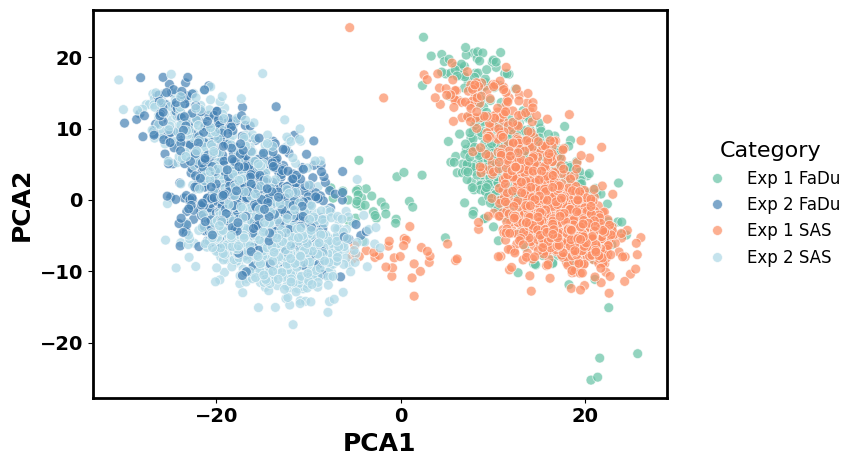

In [30]:
import os
import pandas as pd
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# --- Select dataset to plot: 'short' | 'mid' | 'long' ---
selected_range = 'mid'  # change to 'long' when needed
data = pd.read_csv(dataset_paths[selected_range])

# --- Minimal cleaning & keep needed columns for categorization ---
data = data.dropna(subset=['diagnosis'])
# Ensure numeric plate for comparisons
data['plate'] = pd.to_numeric(data['plate'], errors='coerce')

# Build features/labels; keep well & plate for category logic
well = data['well'].copy()
plate = data['plate'].copy()
X = data.drop(columns=[
    'well', 'DaysofRelapse', 'plate', 'RT', 'time',
    'temperature', 'dose (Gy)', 'CEM43', 'diagnosis'
], errors='ignore')
y = data['diagnosis']

# --- Categorize samples by plate & cell line (FaDu/SAS) ---
def categorize_samples(p, w):
    if pd.notna(p) and p > 45:
        return 'March FaDu' if 'FaDu' in str(w) else ('March SAS' if 'SAS' in str(w) else 'Unknown')
    elif pd.notna(p):
        return 'June FaDu' if 'FaDu' in str(w) else ('June SAS' if 'SAS' in str(w) else 'Unknown')
    return 'Unknown'

data['category'] = [categorize_samples(p, w) for p, w in zip(plate, well)]

# --- Plate-based split (single, no redundant random split) ---
train_indices = plate[plate > 45].index       # "March"
test_indices  = plate[plate <= 45].index      # "June"

X_train, y_train = X.loc[train_indices], y.loc[train_indices]
X_test,  y_test  = X.loc[test_indices],  y.loc[test_indices]

# --- Balance test set by undersampling the majority class ---
test_data = X_test.copy()
test_data['diagnosis'] = y_test
min_count = test_data['diagnosis'].value_counts().min()
balanced_test = pd.concat([
    resample(test_data[test_data['diagnosis'] == lab],
             replace=False, n_samples=min_count, random_state=42)
    for lab in test_data['diagnosis'].unique()
])
X_test = balanced_test.drop(columns=['diagnosis'])
y_test = balanced_test['diagnosis']

# --- Prepare combined table for visualization ---
combined = pd.concat([
    X_train.assign(Source='Train'),
    X_test.assign(Source='Test')
])

combined['category'] = pd.concat([
    data.loc[X_train.index, 'category'],
    data.loc[X_test.index,  'category']
])

# Replace labels to Exp 1/Exp 2 and reorder "Exp X <cell-line>"
combined['category'] = (
    combined['category']
    .str.replace('March', 'Exp 1', regex=False)
    .str.replace('June',  'Exp 2', regex=False)
    .str.replace(r'(^\w+)\s(Exp\s\d)', r'\2 \1', regex=True)
)

ordered_categories = ['Exp 1 FaDu', 'Exp 2 FaDu', 'Exp 1 SAS', 'Exp 2 SAS']
combined['category'] = pd.Categorical(combined['category'],
                                      categories=ordered_categories,
                                      ordered=True)

# --- PCA embedding (keep your font sizes exactly as you had) ---
X_vis_scaled = StandardScaler().fit_transform(
    combined.drop(columns=['Source', 'category'])
)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_vis_scaled)
combined['PCA1'] = pca_result[:, 0]
combined['PCA2'] = pca_result[:, 1]

custom_palette = {
    'Exp 1 FaDu': '#66c2a5',
    'Exp 2 FaDu': 'steelblue',
    'Exp 1 SAS':  '#fc8d62',
    'Exp 2 SAS':  'lightblue'
}

plt.figure(figsize=(9, 5))
sns.scatterplot(
    data=combined,
    x='PCA1', y='PCA2',
    hue='category',
    hue_order=ordered_categories,
    palette=custom_palette,
    s=50, alpha=0.7
)

plt.xlabel("PCA1", fontsize=18, fontweight='bold')
plt.ylabel("PCA2", fontsize=18, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.legend(
    title='Category',
    fontsize=12, title_fontsize=16,
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    borderpad=0.8,
    frameon=False
)

plt.tight_layout()
plt.savefig(
    r"E:\Project_HTWD\TumorSpheroids\Results\Figure S1.pdf",
    format="pdf", bbox_inches="tight", dpi=300
)
plt.show()



Here we plot figure S2

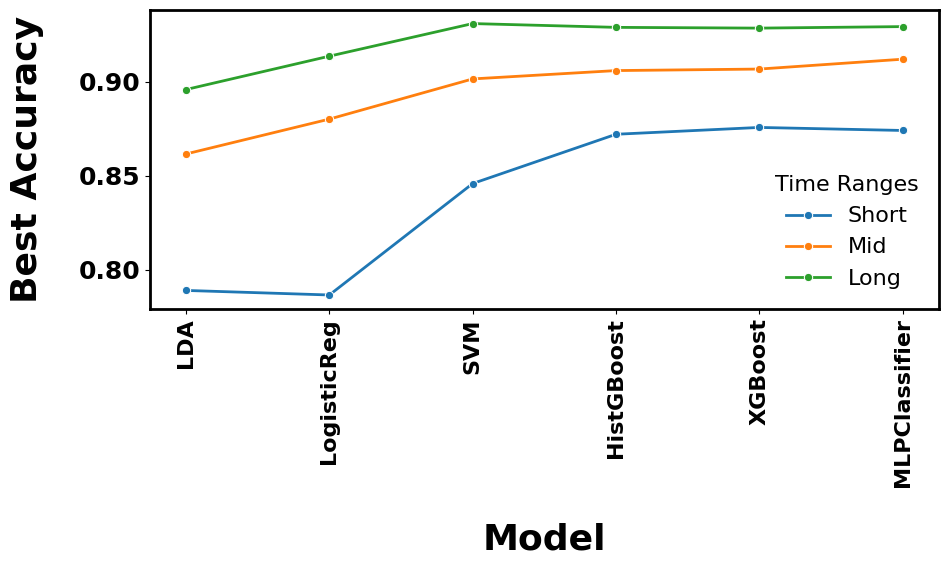

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
paths = {
    'Short': r"E:\Project_HTWD\TumorSpheroids\Results\short_results_combined_auc_acc.csv",
    'Mid':   r"E:\Project_HTWD\TumorSpheroids\Results\mid_results_combined_auc_acc.csv",
    'Long':  r"E:\Project_HTWD\TumorSpheroids\Results\long_results_combined_auc_acc.csv"
}

# Map long model names -> short display names
rename_map = {
    'LogisticRegression': 'LogisticReg',

}

# Load all CSVs once
dataframes = {label: pd.read_csv(path, index_col=0) for label, path in paths.items()}

def extract_best(df, dataset_label):
    # Take only *_Accuracy columns, strip suffix, apply short names
    acc = df.filter(like='_Accuracy').copy()
    acc.columns = acc.columns.str.replace('_Accuracy', '', regex=False)
    acc = acc.rename(columns=rename_map)
    # Best accuracy per model across feature selectors (max down the rows)
    best = acc.max(axis=0)
    out = pd.DataFrame({
        'Model': best.index,
        'BestAccuracy': best.values,
        'Dataset': dataset_label
    })
    return out

df_short_best = extract_best(dataframes['Short'], 'Short')
df_mid_best   = extract_best(dataframes['Mid'],   'Mid')
df_long_best  = extract_best(dataframes['Long'],  'Long')

# Combine all
df_best_all = pd.concat([df_short_best, df_mid_best, df_long_best], ignore_index=True)

# Enforce consistent model order on x-axis
model_order = ['LDA', 'LogisticReg', 'SVM', 'HistGBoost', 'XGBoost', 'MLPClassifier']
df_best_all['Model'] = pd.Categorical(df_best_all['Model'], categories=model_order, ordered=True)

# Enforce dataset order: Short → Mid → Long
dataset_order = ['Short', 'Mid', 'Long']
df_best_all['Dataset'] = pd.Categorical(df_best_all['Dataset'], categories=dataset_order, ordered=True)

# Sort for clean plotting
df_best_all = df_best_all.sort_values(['Dataset', 'Model'])

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_best_all, x='Model', y='BestAccuracy',
             hue='Dataset', hue_order=dataset_order, marker='o', linewidth=2)

# Beautify (keep your font sizes/bold)
plt.xlabel("Model", fontsize=26, fontweight="bold", labelpad=25)
plt.ylabel("Best Accuracy", fontsize=26, fontweight="bold", labelpad=25)
plt.xticks(rotation=90, fontsize=16, fontweight="bold")
plt.yticks(fontsize=18, fontweight="bold")
plt.legend(title="Time Ranges", fontsize=16, title_fontsize=16, frameon=False)

plt.tight_layout()
plt.savefig(r"E:\Project_HTWD\TumorSpheroids\Results\Figure S2.pdf", format="pdf", dpi=300)
plt.show()


Here we provide the values used in Table S.1

In [14]:
import re
import pandas as pd
from pathlib import Path

# -----------------------------------------
# Config
# -----------------------------------------
files = {
    "short": r"E:\Project_HTWD\TumorSpheroids\Results\short_results_combined_auc_acc.csv",
    "mid":   r"E:\Project_HTWD\TumorSpheroids\Results\mid_results_combined_auc_acc.csv",
    "long":  r"E:\Project_HTWD\TumorSpheroids\Results\long_results_combined_auc_acc.csv",
}

# Map shorthand to display names (adjust as needed)
MODEL_NAME_MAP = {
    "HistGBoost": "HistGradientBoosting",
    "HistGradientBoosting": "HistGradientBoosting",
    "XGBoost": "XGBoost",
    "SVM": "SVM",
    "LDA": "LDA",
    "MLPClassifier": "MLPClassifier",
    "LogisticRegression": "LogisticRegression",
    "RandomForest": "RandomForest",
    "GradientBoosting": "GradientBoosting",
    "AdaBoost": "AdaBoost",
    "KNN": "KNN",
    "NaiveBayes": "NaiveBayes",
    "RidgeClassifier": "RidgeClassifier",
}

# -----------------------------------------
# Helpers
# -----------------------------------------
def tidy_one(path: str, range_name: str) -> pd.DataFrame:
    """
    Convert a wide results CSV to tidy format with
    columns: FeatureSelector, Model, <range_name>
    """
    df = pd.read_csv(path)

    # Feature selector column is likely 'Unnamed: 0' (index exported)
    fs_col = "Unnamed: 0" if "Unnamed: 0" in df.columns else df.columns[0]
    df = df.rename(columns={fs_col: "FeatureSelector"})

    # Pick only *_Accuracy columns
    acc_cols = [c for c in df.columns if c.endswith("_Accuracy")]
    if not acc_cols:
        raise ValueError(f"No '*_Accuracy' columns found in {path}. Columns: {list(df.columns)}")

    # Melt to long
    long_df = df.melt(
        id_vars=["FeatureSelector"],
        value_vars=acc_cols,
        var_name="Model_metric",
        value_name=range_name
    )

    # Extract model name from "<Model>_Accuracy"
    long_df["Model"] = long_df["Model_metric"].str.replace(r"_Accuracy$", "", regex=True)

    # Harmonize model display names
    long_df["Model"] = long_df["Model"].map(lambda m: MODEL_NAME_MAP.get(m, m))

    # Keep unique rows and drop the helper column
    long_df = long_df.drop(columns=["Model_metric"])

    # In case there are duplicates per (FS, Model), average within the file
    long_df = (long_df
               .groupby(["FeatureSelector", "Model"], as_index=False)[range_name]
               .mean())
    return long_df

# -----------------------------------------
# Load + Tidy each range and merge
# -----------------------------------------
tidy_parts = {rng: tidy_one(p, rng) for rng, p in files.items()}

merged = (tidy_parts["short"]
          .merge(tidy_parts["mid"],  on=["FeatureSelector", "Model"], how="inner")
          .merge(tidy_parts["long"], on=["FeatureSelector", "Model"], how="inner"))

# Cross-range average
merged["Accuracy"] = merged[["short", "mid", "long"]].mean(axis=1)

# Top 10
top10 = (merged[["FeatureSelector", "Model", "Accuracy"]]
         .sort_values("Accuracy", ascending=False)
         .head(10)
         .copy())

top10["Accuracy"] = top10["Accuracy"].round(4)

# -----------------------------------------
# LaTeX table
# -----------------------------------------
latex_table = top10.to_latex(
    index=False,
    column_format="llr",
    escape=False,
    caption=("Top 10 Feature Selector and ML Model Combinations based on "
             "the accuracy averaged over all observation ranges "
             "(\\emph{short},\\emph{mid},\\emph{long}). We report the average values "
             "to the fourth decimal for the designated ML model and feature selector."),
    label="tab:best_combinations"
)

print(latex_table)

# Optional: save artifacts
out_dir = Path(r"E:\Project_HTWD\TumorSpheroids\Results")
top10.to_csv(out_dir / "top10_featureselector_model_avg_accuracy.csv", index=False)
with open(out_dir / "tab_best_combinations.tex", "w", encoding="utf-8") as f:
    f.write(latex_table)


\begin{table}
\caption{Top 10 Feature Selector and ML Model Combinations based on the accuracy averaged over all observation ranges (\emph{short},\emph{mid},\emph{long}). We report the average values to the fourth decimal for the designated ML model and feature selector.}
\label{tab:best_combinations}
\begin{tabular}{llr}
\toprule
FeatureSelector & Model & Accuracy \\
\midrule
PCA & MLPClassifier & 0.905000 \\
TreeBasedSelector & XGBoost & 0.901700 \\
Mutual_info & MLPClassifier & 0.900900 \\
TreeBasedSelector & HistGradientBoosting & 0.900900 \\
Mutual_info & XGBoost & 0.900600 \\
RFE & MLPClassifier & 0.896700 \\
TreeBasedSelector & MLPClassifier & 0.896000 \\
Mutual_info & HistGradientBoosting & 0.896000 \\
RFE & HistGradientBoosting & 0.894300 \\
RFE & XGBoost & 0.893500 \\
\bottomrule
\end{tabular}
\end{table}



Table S.2

In [15]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from pathlib import Path

# --- config: paths ---
p_short = r"E:\Project_HTWD\TumorSpheroids\Results\short_accuracy_by_DoR.csv"
p_mid   = r"E:\Project_HTWD\TumorSpheroids\Results\mid_accuracy_by_DoR.csv"
p_long  = r"E:\Project_HTWD\TumorSpheroids\Results\long_accuracy_by_DoR.csv"

# Set the row order you want in the LaTeX table:
days_order = [7,10,12,14,17,19,21,24,26,28,31,33]  # change if needed
decimals   = 3

# -------- helpers --------
def pick_col(cols, candidates, fallback=None):
    cols_lower = {c.lower(): c for c in cols}
    for cand in candidates:
        if cand.lower() in cols_lower:
            return cols_lower[cand.lower()]
        # allow substring match (e.g. 'dor' inside 'day_of_relapse')
        for cl, orig in cols_lower.items():
            if cand.lower() == cl or cand.lower() in cl:
                return orig
    if fallback and fallback in cols:
        return fallback
    raise KeyError(f"None of {candidates} found in columns: {list(cols)}")

def load_range(csv_path):
    df = pd.read_csv(csv_path)
    dor_col = pick_col(df.columns, ["DoR","Day of relapse","day_of_relapse","dor","Day"])
    acc_col = pick_col(df.columns, ["Accuracy","accuracy","mean_accuracy","acc"])
    n_col   = pick_col(df.columns, ["N","n","count","total_samples","samples"])
    # Filter DoR <= 36 like your plotting function
    df = df[[dor_col, acc_col, n_col]].rename(columns={dor_col:"DoR", acc_col:"Accuracy", n_col:"N"})
    df = df[df["DoR"] <= 36].copy()
    df.sort_values("DoR", inplace=True)
    return df

def se_binomial(p, n):
    p = np.asarray(p, float); n = np.asarray(n, float)
    out = np.sqrt(np.clip(p,0,1)*np.clip(1-p,0,1)/np.maximum(n,1))
    out[(n<=0)|~np.isfinite(out)] = np.nan
    return out

def wls_exp_pred(days, acc, n):
    """Fit log(acc) ~ a + b*DoR, weights=1/SE^2, return predicted acc at 'days'."""
    days = np.asarray(days, float)
    acc  = np.asarray(acc, float)
    n    = np.asarray(n, float)
    se   = se_binomial(acc, n)
    mask = (acc>0) & (acc<1) & np.isfinite(se) & (se>0)
    if mask.sum() < 2:
        return np.full_like(days, np.nan, dtype=float)
    X = sm.add_constant(days[mask])
    y = np.log(acc[mask])
    w = 1.0/(se[mask]**2)
    fit = sm.WLS(y, X, weights=w).fit()
    return np.exp(fit.predict(sm.add_constant(days)))

def fmt_cell(a, s, f, k=decimals):
    if pd.isna(a) or pd.isna(s):
        return "-"
    if pd.isna(f) or not np.isfinite(f):
        return f"{a:.{k}f} $\\pm$ {s:.{k}f} (-)"
    return f"{a:.{k}f} $\\pm$ {s:.{k}f} ({f:.{k}f})"

# -------- load data --------
df_short = load_range(p_short)
df_mid   = load_range(p_mid)
df_long  = load_range(p_long)

# Compute SE and predictions on each range’s own grid
df_short["SE"]  = se_binomial(df_short["Accuracy"], df_short["N"])
df_mid["SE"]    = se_binomial(df_mid["Accuracy"],   df_mid["N"])
df_long["SE"]   = se_binomial(df_long["Accuracy"],  df_long["N"])

df_short["Pred"] = wls_exp_pred(df_short["DoR"], df_short["Accuracy"], df_short["N"])
df_mid["Pred"]   = wls_exp_pred(df_mid["DoR"],   df_mid["Accuracy"],   df_mid["N"])
df_long["Pred"]  = wls_exp_pred(df_long["DoR"],  df_long["Accuracy"],  df_long["N"])

# Index by day for quick lookup
S = df_short.set_index("DoR")[["Accuracy","SE","Pred"]].to_dict(orient="index")
M = df_mid.set_index("DoR")[["Accuracy","SE","Pred"]].to_dict(orient="index")
L = df_long.set_index("DoR")[["Accuracy","SE","Pred"]].to_dict(orient="index")

def get(D, day):
    if day in D:
        d = D[day]
        return d["Accuracy"], d["SE"], d["Pred"]
    return (np.nan, np.nan, np.nan)

# -------- build final table dataframe --------
rows = []
for d in days_order:
    sa, ss, sf = get(S, d)
    ma, ms, mf = get(M, d)
    la, ls, lf = get(L, d)
    rows.append({
        "Day of relapse": d,
        "Short range": fmt_cell(sa, ss, sf),
        "Mid range":   fmt_cell(ma, ms, mf),
        "Long range":  fmt_cell(la, ls, lf),
    })

table_df = pd.DataFrame(rows)
table_df.to_csv("accuracy_DoR_table.csv", index=False)

# -------- LaTeX body (rows only) --------
latex_rows = []
for _, r in table_df.iterrows():
    latex_rows.append(f"{int(r['Day of relapse'])} & {r['Short range']} & {r['Mid range']} & {r['Long range']}\\\\")
latex_body = "\n".join(latex_rows)

# Save just the tabular rows so you can paste into your table env
Path("accuracy_DoR_table.tex").write_text(latex_body, encoding="utf-8")

print("LaTeX rows:\n")
print(latex_body)
print("\nSaved: accuracy_DoR_table.csv and accuracy_DoR_table.tex")


LaTeX rows:

7 & 0.900 $\pm$ 0.013 (0.899) & 0.958 $\pm$ 0.009 (0.958) & 0.975 $\pm$ 0.007 (0.985)\\
10 & 0.857 $\pm$ 0.044 (0.813) & 0.841 $\pm$ 0.046 (0.847) & 0.968 $\pm$ 0.022 (0.897)\\
12 & 0.696 $\pm$ 0.055 (0.761) & 0.826 $\pm$ 0.046 (0.781) & 0.942 $\pm$ 0.028 (0.843)\\
14 & 0.826 $\pm$ 0.056 (0.711) & 0.717 $\pm$ 0.066 (0.720) & 0.696 $\pm$ 0.068 (0.792)\\
17 & 0.543 $\pm$ 0.073 (0.643) & 0.565 $\pm$ 0.073 (0.636) & 0.630 $\pm$ 0.071 (0.721)\\
19 & 0.487 $\pm$ 0.080 (0.601) & 0.462 $\pm$ 0.080 (0.586) & 0.487 $\pm$ 0.080 (0.678)\\
21 & 0.483 $\pm$ 0.093 (0.562) & 0.586 $\pm$ 0.091 (0.540) & 0.828 $\pm$ 0.070 (0.637)\\
24 & 0.688 $\pm$ 0.116 (0.508) & 0.500 $\pm$ 0.125 (0.478) & 0.688 $\pm$ 0.116 (0.580)\\
26 & 0.500 $\pm$ 0.144 (0.475) & 0.500 $\pm$ 0.144 (0.440) & 0.500 $\pm$ 0.144 (0.545)\\
28 & 0.429 $\pm$ 0.187 (0.445) & 0.714 $\pm$ 0.171 (0.406) & 0.714 $\pm$ 0.171 (0.512)\\
31 & 0.500 $\pm$ 0.177 (0.402) & 0.500 $\pm$ 0.177 (0.359) & 0.500 $\pm$ 0.177 (0.466)\\
33 & 0.40

In [ ]:
import os
import pandas as pd

# --- Configuration ---
input_dir = r"E:/Project_HTWD/timeseries/norm"   # change to your folder
output_file = r"E:/Project_HTWD/file_list.xlsx"  # could also be .tsv

# --- Collect files ---
file_records = []
for root, _, files in os.walk(input_dir):
    for f in files:
        if f.lower().endswith(".png"):
            # build relative path with forward slashes
            rel_path = os.path.relpath(os.path.join(root, f), input_dir)
            rel_path = rel_path.replace("\\", "/")  # ensure forward slash

            file_records.append({"Files": rel_path})

# --- Save as table ---
df = pd.DataFrame(file_records)

# no blank lines, filenames case-sensitive, "Files" is first col
df.to_excel(output_file, index=False)   # Excel
# df.to_csv(output_file.replace(".xlsx", ".tsv"), sep="\t", index=False)  # TSVSAS_SM_ID_20190315_SAS_plate122_03F/14.png
#FaDu_SM_ID_20190315_FaDu_plate101_07B_0.png

print(f"File list created with {len(df)} files → {output_file}")


File list created with 118096 files → E:/Project_HTWD/file_list.xlsx
